# VAE : Variational Auto Encoder



# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 5.6 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

## サンプルデータの定義

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
batch_size = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(len(x_train))

1797


## サンプルデータの図化

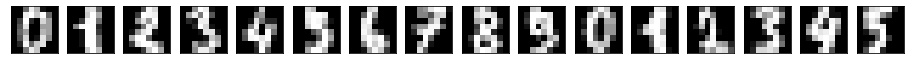

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## ニューラルネットワークの定義

In [8]:
import torch.distributions as tdist

def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum()
  #z = e.sum() / len(y)
  return -z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum()
  #y = 0.5 * g.sum() / len(mean)
  return -y


class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    x1 = F.relu( self.fc1(x) )
    #x1 = F.relu( self.fc1(x1) )
    #x1 = self.bn1( x1 )
    self.mean    = self.fc2_mean( x1 )
    self.log_var = self.fc2_var( x1 )

    # reparametrization
    eps = torch.randn( self.mean.shape )
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )

    # decoder
    y = F.relu( self.fc3( self.z ) )
    #y = self.drop1( self.y )
    y = torch.sigmoid( self.fc4( y ) )
    self.out = y 
    
    e1 = reconstruction( y, x )
    #e1 = F.binary_cross_entropy( y , x, reduction="sum" )
    e2 = kl_divergence( self.mean, self.log_var )

    self.loss1 = e1
    self.loss2 = e2
    return (e1+e2)

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'vae1'
folder = "./test"
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p test

## 計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, e ):
    model = Net( n_in, n_mid, n_out, n_z, e )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

x = x_train.clone().detach()
x = x[0:batch_size,:]
e = torch.randn( batch_size, 2 )
model = generate_json( json_path, x, e )

[SAVE] ./test/vae1.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_mean]/weight/fc2_mean
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc2_var]/weight/fc2_var
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc4]/weight/fc4
skip: Net/Linear[fc4]/weight/fc4


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::randn(%41, %42, %43, %44, %45) # <ipython-input-8-96f948479892>:44:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 7.2154541015625 (up to 1e-05 allowed)
Relative difference: 0.005048025373951766 (up to 1e-05 allowed)
  _module_class,


C++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, x, {"input_data":dd}, sol="vae", epochs=200, batch=32, lr=0.001, pred_key="sigmoid", pred_output=10, z="fc3", shuffle=1 )

[JSON] ./test/vae1.json
param: xin  - str loop  255  /  255
{'name': 'Net/Linear[fc1]/weight/weight.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  127  /  127
{'name': 'Net/Linear[fc1]/bias/bias.11', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  1  /  1
{'name': 'Net/Linear[fc2_mean]/weight/weight.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
param: fc2_mean_weight  - str loop  3  /  3
{'name': 'Net/Linear[fc2_mean]/bias/bias.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
param: fc2_mean_bias  - str loop  0  /  0
{'name': 'Net/Linear[fc2_var]/weight/weight.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [24], 'sorted_id': 22}
param: fc2_var_weight  - str loop  3  /  3
{'name': 'Net/Linear[fc2_var]/bias/bias.15', 'op

In [14]:
# check code
with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  output.backward()
  print("input_grad",x.grad)

output tensor(1428.0901, grad_fn=<AddBackward0>)
input_grad None


# C++予測コード


## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git


In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

## コンパイル

In [16]:
C_SRC = './test/vae1.cpp ./test/vae1_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './test/vae1'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./test/vae1.cpp ./test/vae1_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./test/vae1


In [17]:
!./test/vae1

### forward computation ...
{ 1423.829834}
### backward computation ...
input_grad{{-0.082754, -0.062344, -0.007766, ...,  0.008542, -0.052853,  0.011956},
 {-0.028702, -0.033319, -0.007702, ...,  0.003688, -0.001269,  0.028357},
 {-0.250287, -0.223156,  0.007111, ...,  0.05431 , -0.109969,  0.106161},
 ..., 
 { 0.002704, -0.010902, -0.001357, ..., -0.015014, -0.010815,  0.014793},
 {-0.085785,  0.000741,  0.026928, ...,  0.041416,  0.007625,  0.076885},
 {-0.109081, -0.015153,  0.039404, ...,  0.051356, -0.000163,  0.160405}}


# Python 学習コード

## サイズ32のみデータによる学習ループの実行 (python版)

In [18]:
torch.manual_seed( 1 )

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:batch_size,:]
print(x.shape)

e = torch.randn( batch_size, n_z )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr = 0.001
opt = torch.optim.SGD(net.parameters(), lr)

epoch_loss = []
epoch_num =  200;
for epoch in range(epoch_num):

  loss = net( x )

  print("loss",loss)

  opt.zero_grad()
  loss.backward()
  opt.step()
  print("EPOCH: {} loss: {}".format(epoch, loss))
  epoch_loss.append( float(loss) )
 

torch.Size([32, 64])
loss tensor(1426.7566, grad_fn=<AddBackward0>)
EPOCH: 0 loss: 1426.756591796875
loss tensor(1421.3060, grad_fn=<AddBackward0>)
EPOCH: 1 loss: 1421.3060302734375
loss tensor(1406.0474, grad_fn=<AddBackward0>)
EPOCH: 2 loss: 1406.04736328125
loss tensor(1384.9769, grad_fn=<AddBackward0>)
EPOCH: 3 loss: 1384.9769287109375
loss tensor(1372.6444, grad_fn=<AddBackward0>)
EPOCH: 4 loss: 1372.6444091796875
loss tensor(1351.8621, grad_fn=<AddBackward0>)
EPOCH: 5 loss: 1351.862060546875
loss tensor(1336.6311, grad_fn=<AddBackward0>)
EPOCH: 6 loss: 1336.631103515625
loss tensor(1324.2722, grad_fn=<AddBackward0>)
EPOCH: 7 loss: 1324.272216796875
loss tensor(1309.9812, grad_fn=<AddBackward0>)
EPOCH: 8 loss: 1309.981201171875
loss tensor(1280.3694, grad_fn=<AddBackward0>)
EPOCH: 9 loss: 1280.369384765625
loss tensor(1239.5985, grad_fn=<AddBackward0>)
EPOCH: 10 loss: 1239.5985107421875
loss tensor(1209.2920, grad_fn=<AddBackward0>)
EPOCH: 11 loss: 1209.2919921875
loss tensor(1179

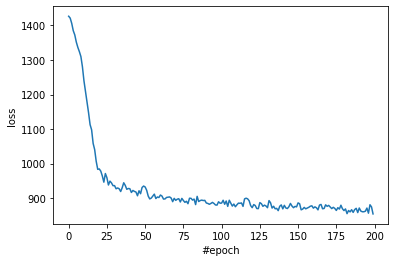

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

O (1797, 64)


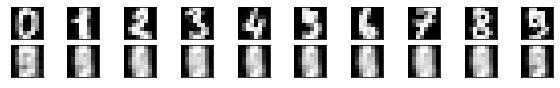

In [20]:
n_img2 = 10
x2 = x_train.clone().detach()
x3 = x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = net( x2 )

o = net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2) )
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## ミニバッチによる全体モデルの学習ループの実行 （python版)

In [21]:
torch.manual_seed( 1 )

epochs = 200
batch_size = 32

e = torch.randn( batch_size, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr = 0.001
opt = torch.optim.SGD(net.parameters(), lr)
#opt = torch.optim.Adam(net.parameters(), lr )

epoch_loss = []
n_batchs = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",batch_size,len(x_train),batch_size)

for i in range(epochs):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batchs):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        
        loss = net( x_mb )
        total_loss += float(loss);

        opt.zero_grad()
        loss.backward()
        opt.step()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
  
    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )

    net.eval()
    loss = net( x2 )
    print("loss",loss,net.loss1,net.loss2)
    epoch_loss.append( float(loss) )

batch 32 1797 32
EPOCH: 0 loss: 59451.65539550781
loss tensor(51891.3555, grad_fn=<AddBackward0>) tensor(49257.7930, grad_fn=<NegBackward0>) tensor(2633.5640, grad_fn=<NegBackward0>)
EPOCH: 1 loss: 51175.46447753906
loss tensor(50899.8008, grad_fn=<AddBackward0>) tensor(48718.8711, grad_fn=<NegBackward0>) tensor(2180.9314, grad_fn=<NegBackward0>)
EPOCH: 2 loss: 50340.441955566406
loss tensor(50122.2070, grad_fn=<AddBackward0>) tensor(48958.0273, grad_fn=<NegBackward0>) tensor(1164.1790, grad_fn=<NegBackward0>)
EPOCH: 3 loss: 49728.050354003906
loss tensor(49535.8203, grad_fn=<AddBackward0>) tensor(48446.8008, grad_fn=<NegBackward0>) tensor(1089.0212, grad_fn=<NegBackward0>)
EPOCH: 4 loss: 48932.33215332031
loss tensor(48553.7969, grad_fn=<AddBackward0>) tensor(47005.9648, grad_fn=<NegBackward0>) tensor(1547.8320, grad_fn=<NegBackward0>)
EPOCH: 5 loss: 48159.81408691406
loss tensor(47910.1211, grad_fn=<AddBackward0>) tensor(46222.5820, grad_fn=<NegBackward0>) tensor(1687.5378, grad_fn=<

収束状況グラフを描画する

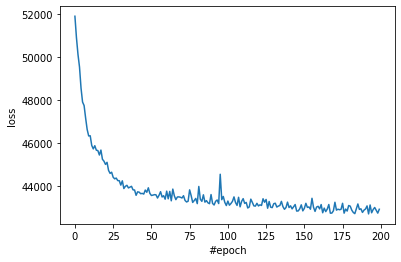

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

O (1797, 64)


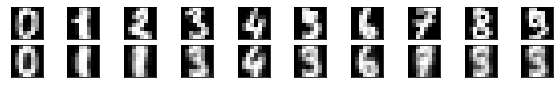

In [23]:
n_img2=10
x2 = x_train.clone().detach()
x3=x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = net( x2 )

o = net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2) )
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

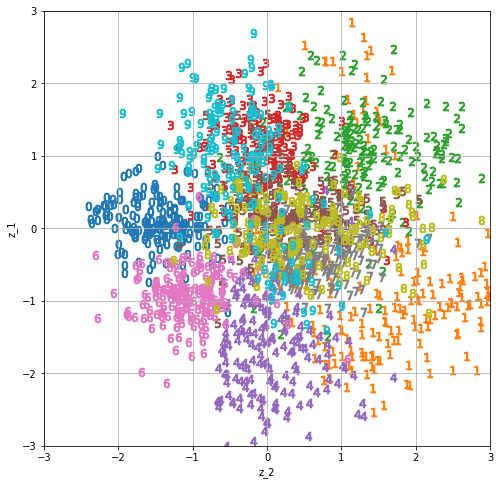

In [24]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = net( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

潜在変数を変化させたときの画像を描画する

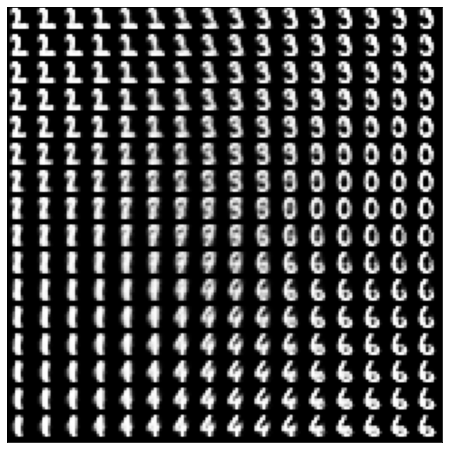

In [25]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

# C++ 学習コード実行

学習用C++コードをコンパイル、リンクする

In [26]:
C_SRC = './test/vae1.cpp ./test/vae1_param.cpp ./test/vae1_data.cpp ./test/vae1_train.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './test/vae1_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./test/vae1.cpp ./test/vae1_param.cpp ./test/vae1_data.cpp ./test/vae1_train.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./test/vae1_train


In [27]:
!./test/vae1_train

epoch_num : 200
batch  number  : 56,32
learning ratio : 0.001
total_loss : epoch 0 - loss 59409.3
epoch 0 - loss 51815.7 ( 49631.1 , 2184.58 ) 
total_loss : epoch 1 - loss 51177.6
epoch 1 - loss 50648.6 ( 49091.4 , 1557.21 ) 
total_loss : epoch 2 - loss 50350.6
epoch 2 - loss 50046.8 ( 48588.7 , 1458.13 ) 
total_loss : epoch 3 - loss 49753.2
epoch 3 - loss 49599.9 ( 48369.1 , 1230.81 ) 
total_loss : epoch 4 - loss 49089.7
epoch 4 - loss 48776.4 ( 47370.8 , 1405.57 ) 
total_loss : epoch 5 - loss 48344.3
epoch 5 - loss 48055.9 ( 46236.2 , 1819.63 ) 
total_loss : epoch 6 - loss 47703.6
epoch 6 - loss 47731 ( 46069.9 , 1661.03 ) 
total_loss : epoch 7 - loss 47351.9
epoch 7 - loss 47216.9 ( 45522.3 , 1694.57 ) 
total_loss : epoch 8 - loss 46963.2
epoch 8 - loss 46798.8 ( 44744.1 , 2054.75 ) 
total_loss : epoch 9 - loss 46610.8
epoch 9 - loss 46569.7 ( 44183.3 , 2386.41 ) 
total_loss : epoch 10 - loss 46184
epoch 10 - loss 46334.5 ( 43853.5 , 2481.06 ) 
total_loss : epoch 11 - loss 46027.5
e

## c++コード実行結果の出力ファイルを読み込む（Python）

In [28]:
#load out file
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("OUT",path)
print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
path = folder + '/' + project + '.pred'
f2 = open( path, 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("PRED",path)
print("pred =", n1,n2 )
#print( y_pred )

# load z file
path = folder + '/' + project + '.z'
f3 = open( path, 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("Z",path)
print("z =", nz1,nz2 )
#print(z_pred)

OUT ./test/vae1.out
epoch = 200
[51815.703125, 50648.617188, 50046.835938, 49599.9375, 48776.40625, 48055.851562, 47730.976562, 47216.875, 46798.8125, 46569.683594, 46334.539062, 46081.34375, 45926.570312, 45689.03125, 45590.503906, 45591.03125, 45503.8125, 45384.273438, 45705.722656, 45123.710938, 45082.34375, 44949.125, 45208.558594, 44739.984375, 44667.421875, 44482.121094, 44573.546875, 44375.363281, 44232.324219, 44062.390625, 44031.570312, 44276.488281, 43985.335938, 43896.617188, 43970.304688, 43818.070312, 44086.105469, 43752.117188, 43615.875, 43847.003906, 43857.363281, 43810.210938, 43737.753906, 43767.800781, 44271.296875, 43530.191406, 43784.425781, 43582.671875, 43885.195312, 43598.699219, 43712.078125, 43706.851562, 43554.609375, 43788.558594, 43571.164062, 43448.84375, 43442.359375, 43621.136719, 43474.015625, 43490.535156, 43550.613281, 44101.789062, 43539.726562, 43604.390625, 43469.835938, 43465.640625, 43435.414062, 43444.308594, 43574.921875, 43299.855469, 43555.24

収束状況グラフを描画する

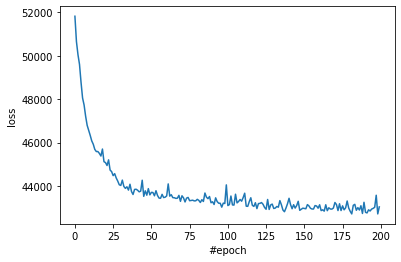

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

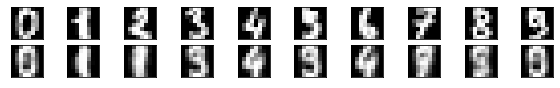

In [30]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

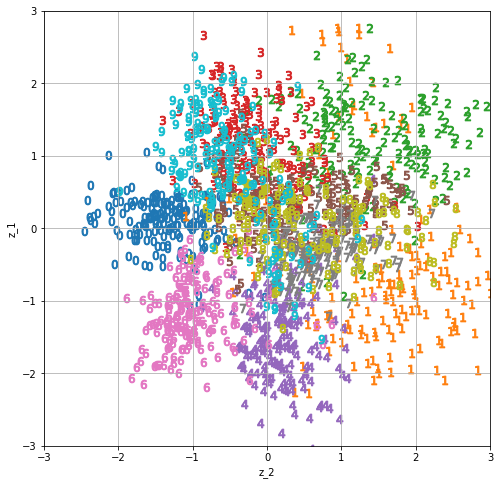

In [31]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

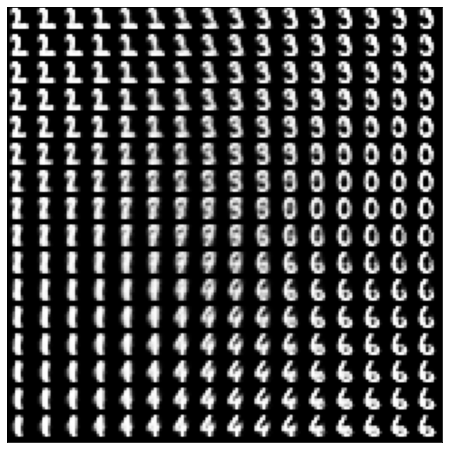

In [32]:
# yet 
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()